### Get Dataset & Create Workspace

In [1]:
import os
import tarfile
from six.moves import urllib

import pandas as pd
import numpy  as np

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [3]:
def fetch_housing_data(
    housing_url=HOUSING_URL, 
    housing_path=HOUSING_PATH):
    
    # create datasets/housing directory if needed
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)

    tgz_path = os.path.join(housing_path, "housing.tgz")
    
    # retrieve tarfile
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    # extract tarfile & close path
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
def load_housing_data(
    housing_path=HOUSING_PATH):
    
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
# do it
#fetch_housing_data() -- already downloaded - static dataset
housing = load_housing_data()

### Data structure - quick peek

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### So... what's in the dataset?

In [7]:
# housing is a Pandas DataFrame.
# untouched datafile: 20640 records, 10 cols (9 float, 1 text)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# let's see if ocean_proximity can be lumped into categories:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
# percentiles analysis of each feature
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a792b5438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4a75d1d1d0>]], dtype=object)

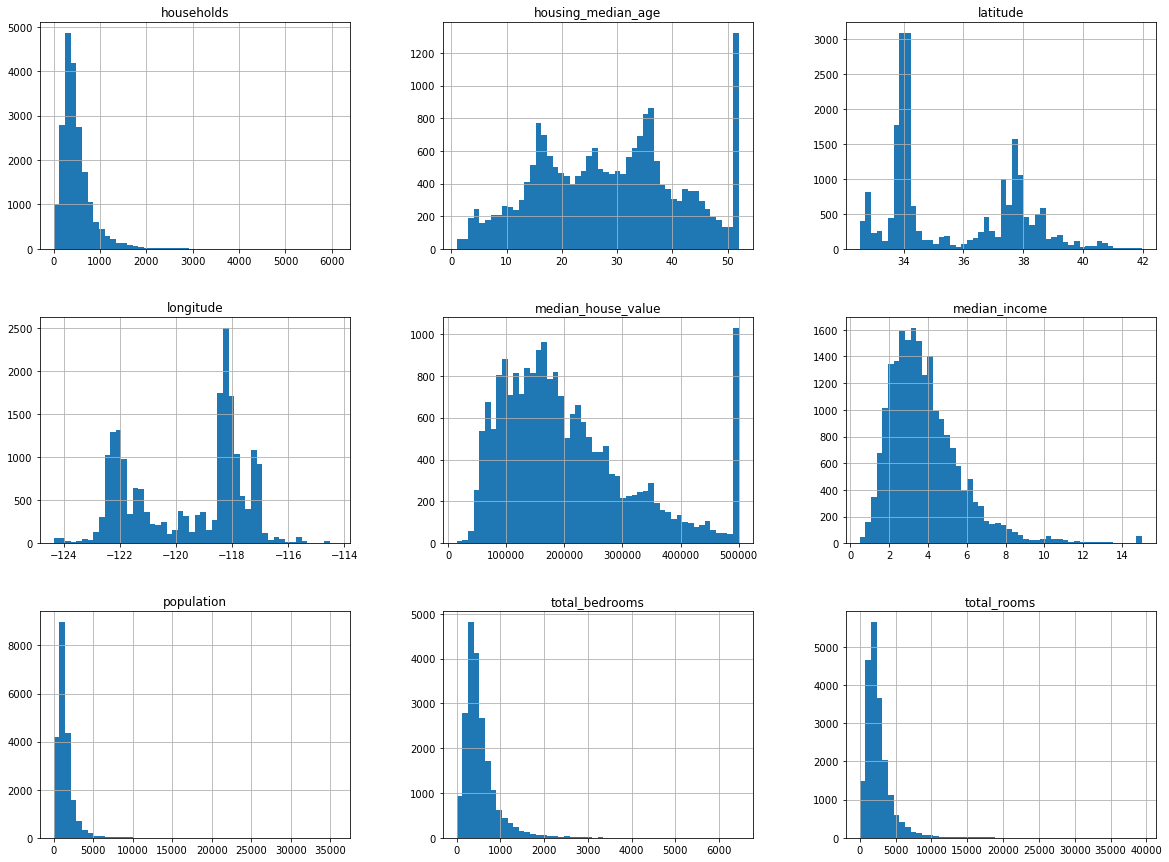

In [10]:
# feature histograms
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))

### Create a test set

In [11]:
# split dataset into training (80%) and test (20%) subsets

import numpy as np

def split_train_test(
    data, test_ratio):

    shuffled_indices = np.random.permutation(len(data))

    test_set_size = int(len(data) * test_ratio)

    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)

In [13]:
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [14]:
# create method for ensuring consistent test sets across multiple runs 
# (new test sets won't contain instances in previous training sets.)

# example method:
# compute hash of each instance
# keep only the last byte
# include instance in test set if value < 51 (20% of 256)

import hashlib

def test_set_check(
    identifier, test_ratio, hash):
    
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(
    data, test_ratio, id_column, hash=hashlib.md5):

    ids = data[id_column]
    in_test_set = ids.apply(
        lambda id_: test_set_check(
            id_, test_ratio, hash))

    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
# housing dataset doesn't have ID attribute,
# so let's add an index to it.

housing_with_id = housing.reset_index()

train_set, test_set = split_train_test_by_id(
    housing_with_id, 0.2, "index")

In [16]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [17]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


In [18]:
# a better index:
# let's use longitude & latitude to build stable identifier

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

train_set, test_set = split_train_test_by_id(
    housing_with_id, 0.2, "id")

In [19]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [20]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [21]:
# another option: scikit-learn splitters

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(
    housing, test_size=0.2, random_state=42)

In [22]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [23]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


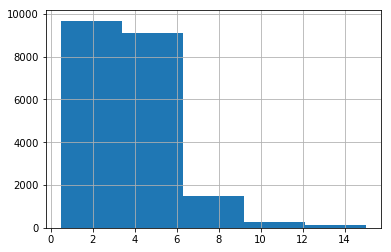

In [24]:
# does sampling plan have a sampling bias?
# each strata in test dataset should mimic reality

housing['median_income'].hist(bins=5)

In [25]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [26]:
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)

housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)

In [27]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,3.006686
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,1.054618
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,1.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,2.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,3.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,4.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,5.000000


In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set  = housing.loc[test_index]

In [29]:
# review income category proportions
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [30]:
# remove income_cat attribute (return dataset to original state)

for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

### Visualization

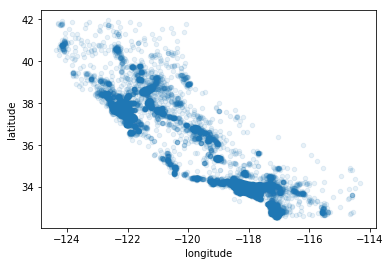

In [31]:
housing = strat_train_set.copy()

# first: basic geographic distribution

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

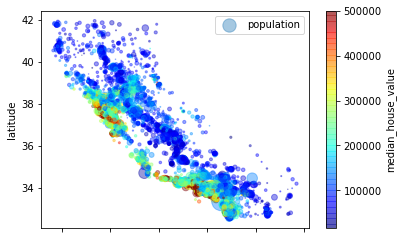

In [32]:
# next: housing prices.
# color = price 
# radius = population
# use predefined "jet" color map 

housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    alpha=0.4,
    #s=housing["population"].apply(lambda n: n/100), 
    s=housing["population"]/100,
    label="population",
    c="median_house_value", 
    cmap=plt.get_cmap("jet"), 
    colorbar=True,
)
plt.legend()

### Correlations

In [33]:
# next: look for correlatons to median house value.

corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15f5fc20f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f15f43960f0>]], dtype=object)

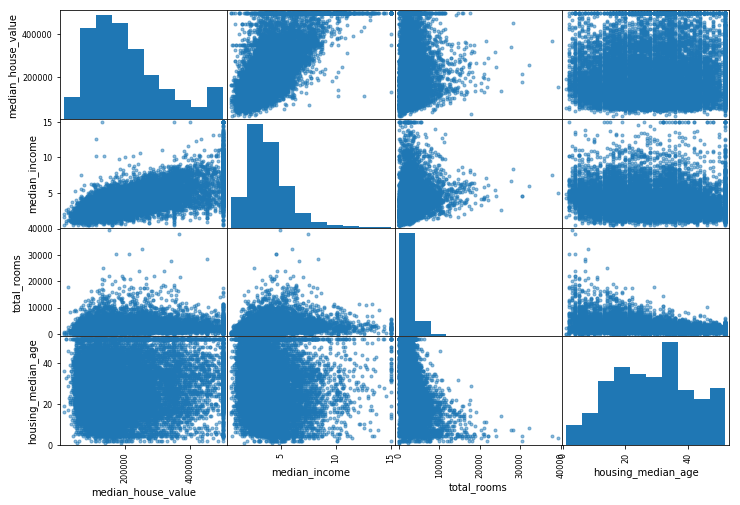

In [34]:
# another way of looking for correlations: scatter_matrix
# focus on top 3 factors from above

from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))

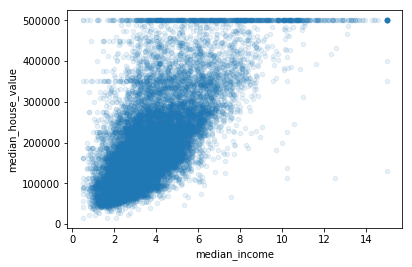

In [35]:
# median house value to median income seems to be the most promising.
# let's zoom in.

housing.plot(
    kind="scatter", x="median_income", y="median_house_value",
    alpha=0.1)

In [36]:
# combine some attributes to create more useful ones
# then rebuild the correlation matrix.

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

# *** NOTE: rooms_per_household corr (in book) show more improvement, ~0.199
# compared to our 0.146. Not sure of root cause yet. ***

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### Data Cleanup

In [37]:
# revert to clean copy of stratified training dataset
# separate predictors from labels

housing = strat_train_set.drop("median_house_value", axis=1)

housing_labels = strat_train_set["median_house_value"].copy()


In [38]:
# 'total bedrooms' has some missing values - fix
# can use DataFrame dropna(), drop(), fillna()

# use Scikit-Learn class to handle missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

In [39]:
# drop ocean_proximity attribute, since it's non-numeric.
# then fit to training data.

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [40]:
# now what do we have?
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [41]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [42]:
# update training set by replacing missing values with learned medians
X = imputer.transform(housing_num)

In [43]:
pd.DataFrame(X, columns=housing_num.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


In [44]:
# convert ocean_proximity feature to numbers using LabelEncoder.

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [45]:
# how is 'ocean_proximity' mapped?
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [46]:
# a better solution for categorical data: one-hot encoding

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# output = SciPy sparse matrix, better for memory usage
# if you need a dense NumPy array, call toarray()

housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

### [Label Binarization:](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)
- A shortcut (text categories => integer categories => one-hot vectors)

In [47]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### Custom Transformers:

* Create your own using SciKit-Learn classes
* implement fit(), transform() and fit_transform() methods
* (fit_transform comes for free by using TransformerMixin as a base class.)

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household      = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, 
                         rooms_per_household, 
                         population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, 
                         rooms_per_household, 
                         population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

* Min-max scaling (normalization) = shift & rescale to [0,1]
* SciKit MinMaxScaler will do this for you.
* Standardization subtracts mean & divides by variance - result has unit variance
* SciKit StandardScaler does this for you.

### Pipelining

* SciKit Pipeline class helps to standardize the sequence of transforms
  you need for your project.
* Pipelines = list of estimator steps. All but the last must be transformers
  (they must have fit_transform() method.)

In [49]:
# "DataFrameSelector" is a custom transformer class.
# grabs the specified feature, drops the rest, converts the DF into a NumPy array.

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__ (self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit (self, X, y=None):
        return self
    
    def transform (self, X):
        return X[self.attribute_names].values
    

In [50]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector',      DataFrameSelector(num_attribs)),
    ('imputer',       Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler',    StandardScaler()),
    ])

cat_pipeline = Pipeline([
    ('selector',      DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list =[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [51]:
# let's try it out:

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [52]:
housing_prepared.shape

(16512, 16)

* Note: 
    pip3 install sklearn-pandas => gets a DataFrameMapper class

### Model Selection & Training

In [53]:
# let's start with a linear regression

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [54]:
# first try. NOT very accurate.

some_data          = housing.iloc[:5]
some_labels        = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print ("predictions:\t", lin_reg.predict(some_data_prepared))
print ("labels:\t", list(some_labels))

predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
labels:	 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [55]:
# why? look at RMSE on whole training set.

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse             = mean_squared_error(housing_labels, housing_predictions)
lin_rmse            = np.sqrt(lin_mse)

print ("typical prediction error:\t", lin_rmse)

typical prediction error:	 68628.1981985


In [56]:
# Hmmm. Not good. Underfit situation. 
# Let's try a more powerful model, like a Decision Tree.

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [57]:
# Zero error? No way...

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

print ("typical prediction error:\t", tree_rmse)

typical prediction error:	 0.0


In [58]:
# Use K-fold cross-validation
# Train & eval Decision Tree model against 10 splits of training dataset
# Returns 10 evaluation scores.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    tree_reg, 
    housing_prepared, 
    housing_labels,
    scoring="neg_mean_squared_error", 
    cv=10)

rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(rmse_scores)

Scores: [ 69368.62190153  66248.56520386  72284.6557095   68417.57732406
  70049.44916939  74941.75765797  70236.59348749  69466.63688954
  76140.22952307  70217.59755116]
Mean: 70737.1684418
Standard deviation: 2815.58298405


In [59]:
# So, Decision Tree RMSE: mean ~71097, stdev 2165 (still sucks.)
# compare to earlier Linear Regression:

lin_scores = cross_val_score(
    lin_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


In [60]:
# Yep, DT overfit is just about as bad. (RMSE mean 69052, stdev 2731)
# Let's try a RandomForest.

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(
    forest_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [ 52480.82629458  50035.41358467  53747.69332484  55053.95194112
  51800.65152945  55919.01705209  52226.75176017  50912.82366116
  55708.47271341  51931.81080304]
Mean: 52981.7412665
Standard deviation: 1929.32402243


In [61]:
# OK, RandomForest is a little better.
# RMSE mean ~52495, stdev ~1569

### Fine-Tuning Model with Grid Search of Hyperparameters

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 
     'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], # bootstrap = True = default setting
     'n_estimators': [3, 10], 
     'max_features': [2, 3, 4]},
]

forest_reg  = RandomForestRegressor()

grid_search = GridSearchCV(
    forest_reg, 
    param_grid, 
    cv=5,
    scoring = 'neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [63]:
# Best combination of parameters?
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [64]:
# Best estimator?
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [65]:
# Evaluation scores:

cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"],
                              cvres["params"]):
    print(np.sqrt(-mean_score), params)

63492.9975584 {'max_features': 2, 'n_estimators': 3}
55677.1037862 {'max_features': 2, 'n_estimators': 10}
52917.801725 {'max_features': 2, 'n_estimators': 30}
60442.2787178 {'max_features': 4, 'n_estimators': 3}
53209.7111283 {'max_features': 4, 'n_estimators': 10}
50621.1191846 {'max_features': 4, 'n_estimators': 30}
58591.8196313 {'max_features': 6, 'n_estimators': 3}
52353.3606044 {'max_features': 6, 'n_estimators': 10}
49838.3807 {'max_features': 6, 'n_estimators': 30}
58615.6100561 {'max_features': 8, 'n_estimators': 3}
51726.2593734 {'max_features': 8, 'n_estimators': 10}
50074.3050139 {'max_features': 8, 'n_estimators': 30}
62010.5215854 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54852.7770725 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60246.2164711 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52752.4109521 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58355.1846204 {'bootstrap': False, 'max_features': 4, 'n_estimator

In [66]:
# best solution:
# max_features = 6, n_estimators = 30 (RMSE ~49,960)

In [67]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  8.00229340e-02,   7.13499357e-02,   4.21346911e-02,
         1.73340009e-02,   1.55694906e-02,   1.76527489e-02,
         1.56813711e-02,   3.21068169e-01,   7.54675530e-02,
         1.07645094e-01,   5.74608930e-02,   1.47327045e-02,
         1.57310792e-01,   9.20951468e-05,   2.63317542e-03,
         3.84435167e-03])

In [68]:
# display feature "importance" scores next to their names:

extra_attribs       = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes          = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.32106816893273865, 'median_income'),
 (0.15731079177984286, 'INLAND'),
 (0.10764509417315272, 'pop_per_hhold'),
 (0.080022934000105003, 'longitude'),
 (0.075467553036607335, 'rooms_per_hhold'),
 (0.071349935674308126, 'latitude'),
 (0.057460893036370447, 'bedrooms_per_room'),
 (0.04213469106714228, 'housing_median_age'),
 (0.017652748894983483, 'population'),
 (0.017334000890698829, 'total_rooms'),
 (0.015681371107232313, 'households'),
 (0.015569490624941605, 'total_bedrooms'),
 (0.014732704544371122, '<1H OCEAN'),
 (0.0038443516681782959, 'NEAR OCEAN'),
 (0.00263317542255579, 'NEAR BAY'),
 (9.2095146771177451e-05, 'ISLAND')]

### Time to Eval System on Test dataset

In [69]:
final_model = grid_search.best_estimator_

X_test          = strat_test_set.drop("median_house_value", axis=1)
y_test          = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47574.62166586089